# Ann Arbor Housing Survey: Exploratory Data Analysis
<hr>

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import re
import json

In [116]:
df = pd.read_json('../data/aggregated.json')
df.head()

,address,price,bed,bath,area,company,neighborhood,laundry,pets,parking,utilities,property_type,year_built,description,images
0,3050 Birch Hollow Dr,1095.0,2.0,1.0,876.0,None,None,1.0,1.0,1.0,[],apartment,NaN,This bedroom apartments includes:\n\n→ Contemp...,[https://images.craigslist.org/00S0S_8ZkasrSZ6...
1,912 Rose Ave,2000.0,4.0,2.5,2000.0,None,None,1.0,1.0,1.0,[],house,NaN,"Stunning Ann Arbor home, perfect family house ...",[https://images.craigslist.org/00Y0Y_4tey2xf24...
2,None,695.0,3.0,2.0,NaN,None,None,1.0,0.0,1.0,[],apartment,NaN,"AWESOME Affordable. This stunning 3 bedroom, 1...",[]
3,1505 Natalie Lane near Kipling Drive,1385.0,1.0,1.0,800.0,None,None,1.0,1.0,1.0,[],apartment,NaN,Have you heard about our Stars & Stripes progr...,[https://images.craigslist.org/00p0p_1PnkFaSsW...
4,1505 Natalie Lane near Kipling Drive,1185.0,1.0,1.0,800.0,None,None,1.0,1.0,1.0,[],apartment,NaN,Have you heard about our Stars & Stripes progr...,[https://images.craigslist.org/00k0k_7n7PgfXF5...


In [38]:
df.describe()

,price,bed,bath,area,laundry,pets,parking,year_built
count,7818.000000,8519.000000,9203.000000,5965.000000,7302.000000,7302.000000,7302.000000,1766.000000
mean,1583.984971,2.094847,1.414919,978.319950,0.944399,0.492468,0.644618,1974.872593
std,1095.510351,1.566232,0.782912,548.638798,0.229166,0.499977,0.478662,34.674417
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1870.000000
25%,989.000000,1.000000,1.000000,658.000000,1.000000,0.000000,0.000000,1964.000000
50%,1299.000000,2.000000,1.000000,888.000000,1.000000,0.000000,1.000000,1987.000000
75%,1725.000000,2.000000,2.000000,1100.000000,1.000000,1.000000,1.000000,1998.000000
max,15900.000000,12.000000,10.000000,8500.000000,1.000000,1.000000,1.000000,2020.000000


### Distribution of Price

The first graph (excluding some very high outliers around 15000) shows a histogram and KDE of the overall price distribution. The second graph uses a log-linear scale and plots both the histogram and a rug plot to give a better impression of the actual price distribution; the plot shows characteristics of a long tail. 

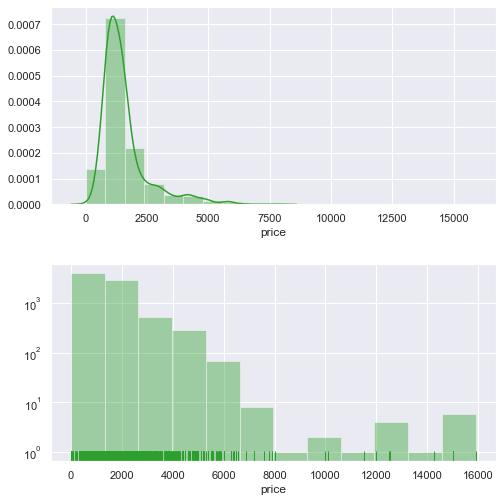

In [11]:
sns.set(style='darkgrid')
plt.subplots(2, 1, figsize=(7,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.subplot(2, 1, 1)
ax1 = sns.distplot(df['price'], kde_kws={'bw':200, 'clip':[-1000, 10000]}, bins=20, color='#2ca02c')
plt.ticklabel_format(style='plain', axis='y')
plt.subplot(2, 1, 2)
ax2 = sns.distplot(df['price'], bins=12, color='#2ca02c', kde=False, rug=True)
ax2.set_yscale('log')
plt.savefig('price-dist.png', dpi=300)

Some descriptive statistics of the price distribution:

In [12]:
df['price'].describe()

count     7818.000000
mean      1583.984971
std       1095.510351
min          1.000000
25%        989.000000
50%       1299.000000
75%       1725.000000
max      15900.000000
Name: price, dtype: float64

### Joint Distribution of Price and Area
This plot shows the joint (and marginal) distribution(s) of price and area. There is a clear positive association, although variance tends to increase as either variable increases. Most listings seem to cost between 500 and 2000 dollars and have total areas between 300 and 1200 square feet.

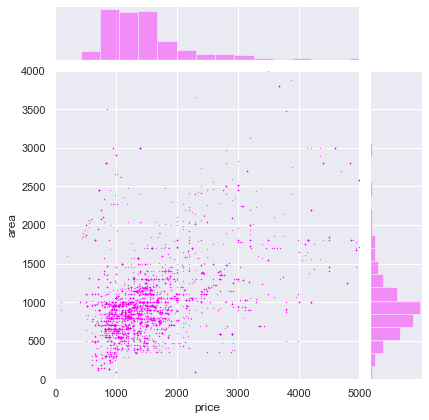

In [21]:
area = df[df['area'].notnull() & df['area'] != 0]['area']
df_plot = df.copy()
df_plot['area'] = area

# ignore outliers! plot does NOT show long tail
sns.set(style='darkgrid')
g = sns.jointplot('price', 'area', df_plot, kind='scatter', alpha=0.8, s=0.1, color='magenta')
g.ax_joint.set_ylim([0, 4000])
g.ax_joint.set_xlim([0, 5000])
plt.savefig('area-vs-price.png', dpi=300)

### Correlation Heatmap
The correlation heatmap below shows that intuitive trends are reflected in the data; for instance, we'd expect that price is highly correlated with the number of available bedrooms in a house or apartment. Note that many of the other correlations are relatively weak.

,price,bed,bath,area,laundry,pets,parking,year_built
price,1.000000,0.630296,0.340268,0.460245,-0.066057,-0.195342,-0.081144,0.253818
bed,0.630296,1.000000,0.666135,0.669075,-0.027155,-0.080173,0.076723,-0.237187
bath,0.340268,0.666135,1.000000,0.578336,-0.002040,-0.093690,0.057643,0.221848
area,0.460245,0.669075,0.578336,1.000000,-0.056068,-0.123596,0.066532,0.245898
laundry,-0.066057,-0.027155,-0.002040,-0.056068,1.000000,0.193587,0.203173,0.404787
pets,-0.195342,-0.080173,-0.093690,-0.123596,0.193587,1.000000,0.320473,NaN
parking,-0.081144,0.076723,0.057643,0.066532,0.203173,0.320473,1.000000,0.175739
year_built,0.253818,-0.237187,0.221848,0.245898,0.404787,NaN,0.175739,1.000000


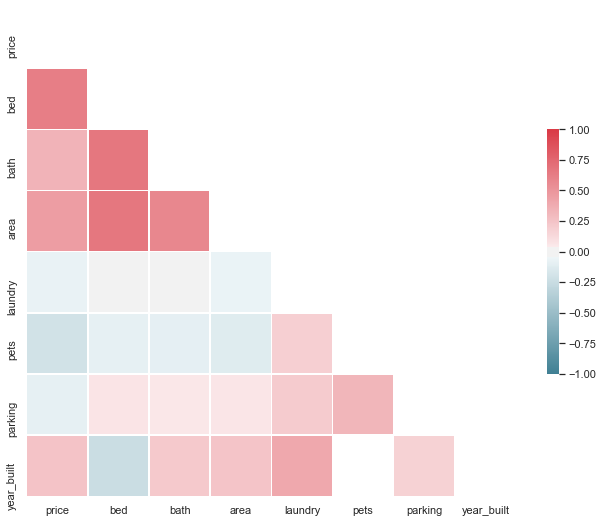

In [13]:
sns.set(style='white')
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('corr-heatmap.png', dpi=300)
corr

### Distribution of Price by Company
We took the 10 most common companies and visualized the distribution of price by each of these companies.

Cabrio Properties                       318
Campus Management, Inc.                 206
PMSI                                    177
Oxford Property Management              176
J Keller Properties                     169
The Hayman Company                      138
Oakland Management Corp.                130
Cappo Management & Deinco Properties    123
Issa Properties                         112
Village Green                           102
Name: company, dtype: int64


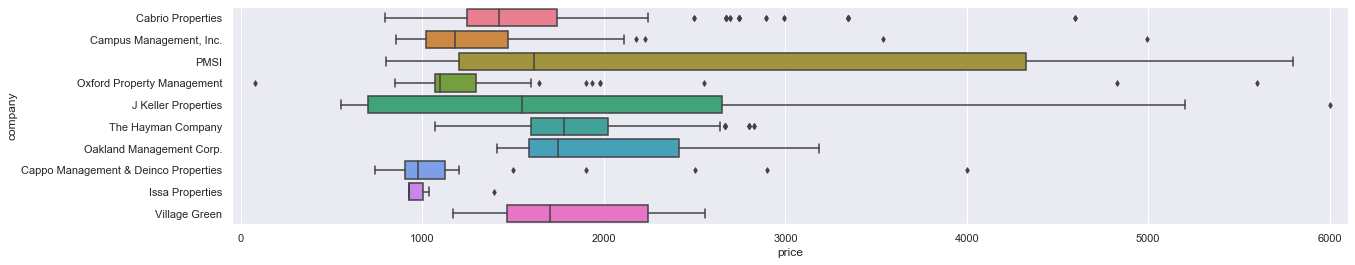

In [116]:
df_plot = df.copy()
companies = df['company'].value_counts().iloc[:10].index.tolist()
print(df['company'].value_counts().iloc[:10])

df_plot = df_plot[df_plot['company'].isin(companies)]
sns.set(style='darkgrid')
plt.subplots(1,1, figsize=(20,4))
sns.boxplot(x='price', y='company', palette="husl", data=df_plot, fliersize=4, order=companies, saturation=0.8)
plt.xlim([-50, 6100])
plt.savefig('boxplot-company.png', dpi=300)


Great
Arbor
Properties,
Inc

Great
Arbor
Properties,
Inc

Great
Arbor
Properties,
Inc

Keller
Williams
Realty
Ann
Arbor
Campus
Village
Communities
Campus
Village
Communities
Campus
Village
Communities
Campus
Village
Communities
Campus
Village
Communities
Campus
Village
Communities
Campus
Village
Communities
Hartman
&
Tyner,
Inc.
Hartman
&
Tyner,
Inc.
Hartman
&
Tyner,
Inc.
Hartman
&
Tyner,
Inc.
Allmand
Properties
Stuart
Frankel
Development
Co.
Stuart
Frankel
Development
Co.
Stuart
Frankel
Development
Co.
Stuart
Frankel
Development
Co.
Stuart
Frankel
Development
Co.
Stuart
Frankel
Development
Co.
Stuart
Frankel
Development
Co.
Stuart
Frankel
Development
Co.
Storypoint
Storypoint
Storypoint
Storypoint
Storypoint
Storypoint
Storypoint
Storypoint
Storypoint
Storypoint
Storypoint
Storypoint
The
Hayman
Company
The
Hayman
Company
The
Hayman
Company
The
Hayman
Company
The
Hayman
Company
The
Hayman
Company
The
Hayman
Company
The
Hayman
Company
The
Hayman
Company
The
Hayman
Company
The
Hayman
Co

The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
The
Habitat
Company
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.
Oakland
Management
Corp.


University
Towers
University
Towers
University
Towers
University
Towers
University
Towers
University
Towers
University
Towers
University
Towers
University
Towers
University
Towers
Powered
by
221B
Woodbury
Management
Woodbury
Management
Woodbury
Management
Woodbury
Management
Woodbury
Management
Woodbury
Management
Woodbury
Management
Woodbury
Management
PMSI
Powered
by
221B
Pappasrentals
Pappasrentals
Pappasrentals
Pappasrentals
Cappo
Management
&
Deinco
Properties
CMB
Management
CMB
Management
CMB
Management
Cabrio
Properties
Cabrio
Properties
Cabrio
Properties
Cabrio
Properties
Cabrio
Properties
Cabrio
Properties
CMB
Management
CMB
Management
CMB
Management
Woodbury
Management
Woodbury
Management
Woodbury
Management
Woodbury
Management
Woodbury
Management
Woodbury
Management
CMB
Management
CMB
Management
Powered
by
221B
PTP
Management
PTP
Management
PTP
Management
PTP
Management
Hemlane
Hemlane
Tom

Clark
Apartments
Tom

Clark
Apartments
Tom

Clark
Apartments
Tom

Clark
Apartments
To

Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Management,
Inc.
Campus
Managemen

Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
J
Keller
Properties
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
Prime
Student
Housing
J
Keller
Properties
J
Keller
Properties
J
Keller
Properties
J
Keller
Properties
J
Keller
Properties
J
Keller
Properties
J
Keller
Properties
J
Keller
Properties
J
Keller
Properties
J
Keller
Properties
J
Keller
Properties
J
Keller
Properties
J
Kell

Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Baker
Street
Properties
Baker
Street
Properties
Baker
Street
Properties
Baker
Street
Properties
Baker
Street
Properties
Baker
Street
Properties
Campus
Apartments
Management,
LLC
Campus
Apartments
Management,
LLC
Campus
Apartments
Management,
LLC
Campus
Apartments
Management,
LLC
Campus
Apartments
Management,
LLC
Campus
Apartments
Management,
LLC
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Street
Investments
Hill
Stre

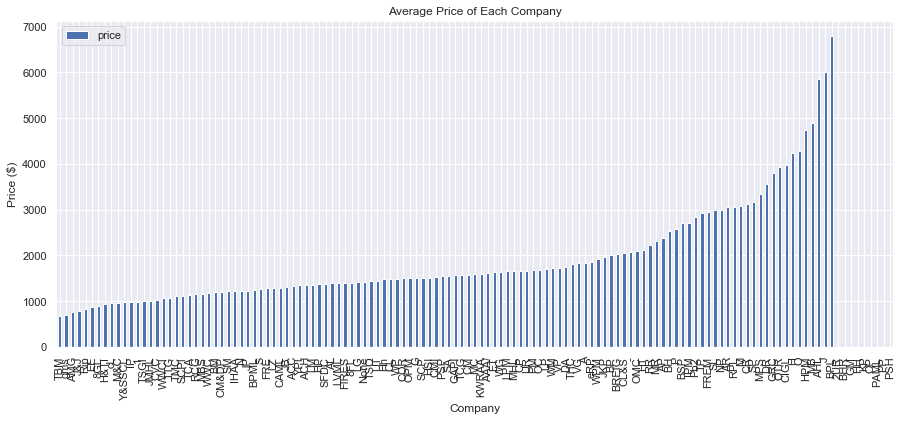

In [117]:
def make(string):
    if string != None and string != '':
        lst = string.split(" ")
        new = ''
        for i in lst:
            print(i)
            if i != '':
                new += i[0]
        return(new)
    return("None")

# only run this once per notebook
df["company"] = df["company"].apply(make) 

group = df.groupby("company").mean()
group = group.sort_values(by=["price"])

group.plot.bar(y=["price"], figsize=(15,6))
plt.title("Average Price of Each Company")
plt.ylabel("Price ($)")
plt.xlabel("Company")
plt.savefig("Average_price_of_companies", dpi=300)

In [118]:
df.company

0       None
1       None
2       None
3       None
4       None
        ... 
9369    None
9370    None
9371    None
9372    None
9373    None
Name: company, Length: 9374, dtype: object

### Distribution of Price by Number of Bathrooms

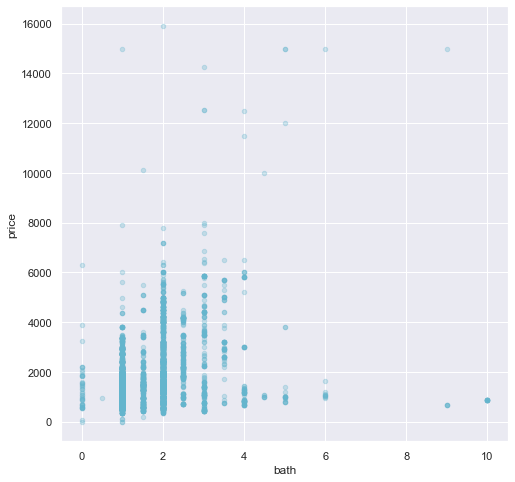

In [95]:
df.plot(kind='scatter', x='bath', y='price', color='c', figsize=(8,8), alpha=0.3) # add jitter?

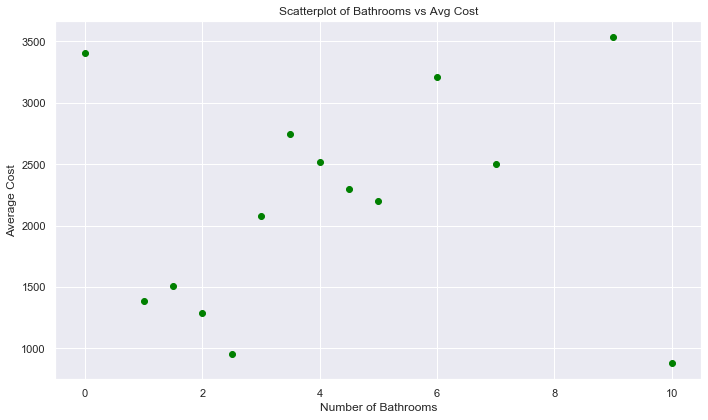

In [79]:
# Average cost
price_per_bath = df.groupby('bath')['price'].mean()
x1 = df['bath'].unique()
y1 = price_per_bath
x1 = x1[~np.isnan(x1)]

sns.set(style='darkgrid')
plt.figure(figsize=(10,6))
plt.scatter(x=x1, y=y1, color='green')
plt.title('Scatterplot of Bathrooms vs Avg Cost')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Average Cost')
plt.tight_layout()

### Distribution of Price by Pet Status

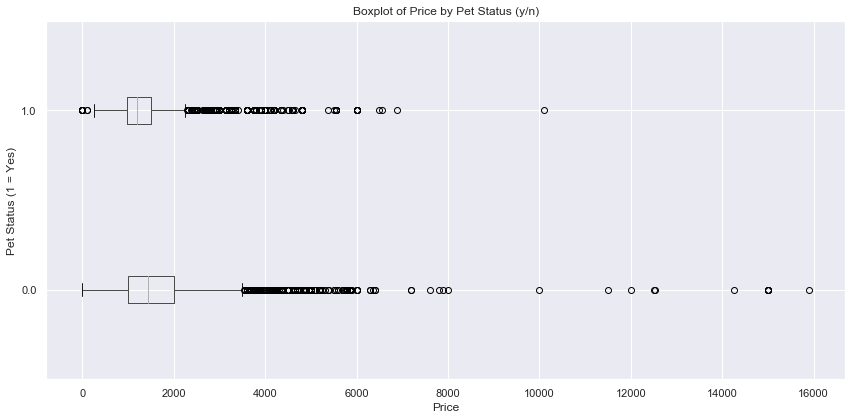

In [21]:
df.boxplot(column='price', by='pets', figsize=(12,6), vert=False)
plt.suptitle('') # removed default subtitle, it overlaps with title
plt.title('Boxplot of Price by Pet Status (y/n)')
plt.ylabel('Pet Status (1 = Yes)')
plt.xlabel('Price')
plt.tight_layout()

### Distribution of Price by Parking Status

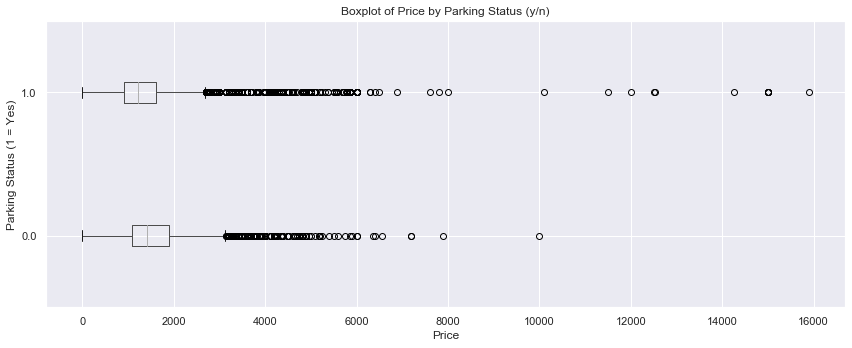

In [31]:
# PARKING STATUS
df.boxplot(column='price', by='parking', vert=False, figsize=(12,5))
plt.suptitle('') # removed default subtitle, it overlaps with title
plt.title('Boxplot of Price by Parking Status (y/n)')
plt.ylabel('Parking Status (1 = Yes)')
plt.xlabel('Price')
plt.tight_layout()

### Distribution of Price by Laundry Status

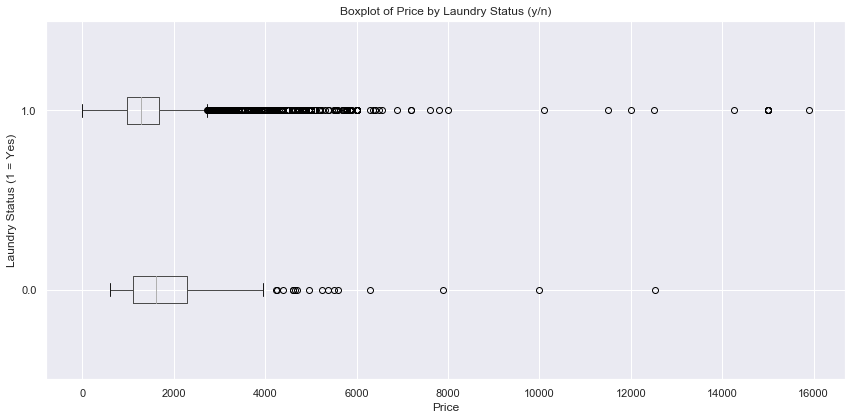

In [25]:
df.boxplot(column='price', by='laundry', vert=False, figsize=(12,6))
plt.suptitle('') # removed default subtitle, it overlaps with title
plt.title('Boxplot of Price by Laundry Status (y/n)')
plt.ylabel('Laundry Status (1 = Yes)')
plt.xlabel('Price')
plt.tight_layout()

### Marginal Distributions of Quantitative Variables 

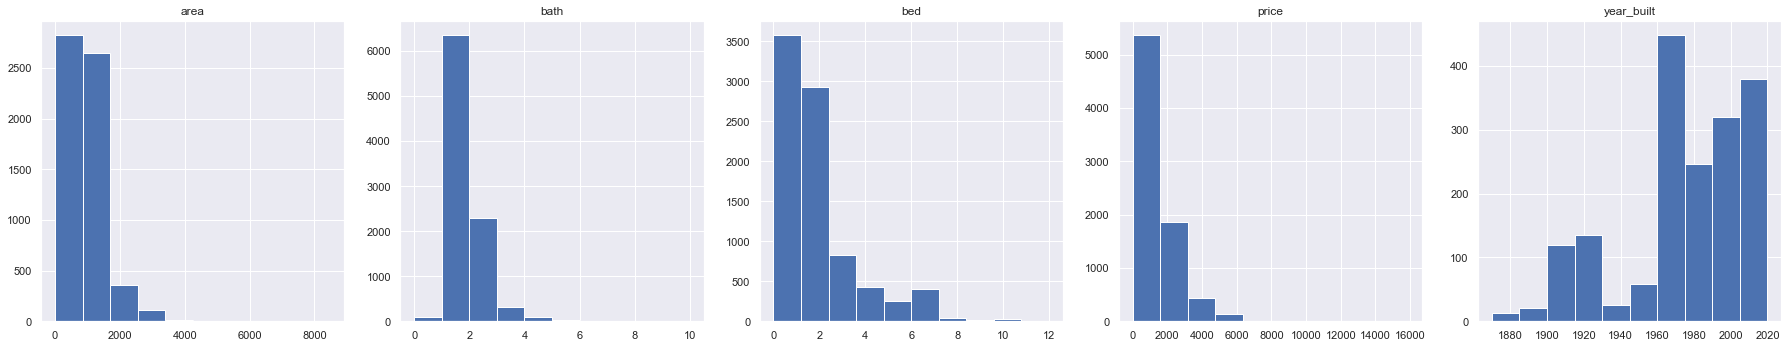

In [75]:
df_plot = df.drop(['laundry', 'parking', 'pets'], axis=1)
df_plot.hist(figsize=(25,5), layout=(1,5));
plt.tight_layout()

### Marginal Distributions of Binary Variables

In [48]:
df_plot = df[['laundry', 'parking', 'pets']]
plt.bar(figsize=(7,8), layout=(4,2));
plt.tight_layout()

AttributeError: 'DataFrame' object has no attribute 'bar'

### Distribution of Price by Property Type

In [62]:
#Property Type and their price mean
dfProp = df.groupby('property_type').mean()
dfProp.price

property_type
-                1622.931034
4plex            1800.000000
apartment        1479.435951
condo            1585.821429
cottage/cabin      99.000000
dorm-style        725.000000
duplex           1934.670270
flat             1510.000000
garden style      995.000000
house            2176.715596
loft             1707.400000
room              838.500000
room for rent    2581.666667
studio           1459.833333
townhome         2672.400000
townhouse        1675.228070
triplex          1600.000000
Name: price, dtype: float64

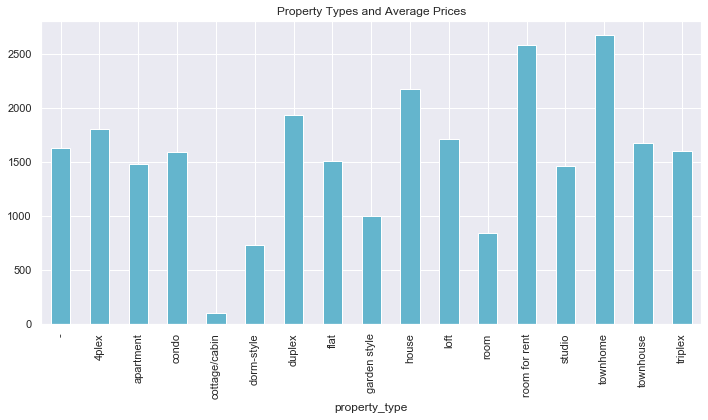

In [77]:
dfProp.price.plot(kind='bar', title = 'Property Types and Average Prices', color='c', figsize=(10,6))
plt.tight_layout()
plt.savefig('Property vs Average Price', dpi=300)